# Forecast Harga Pasar Komoditas Bawang Merah di Brebes

## Import Libraries

In [176]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten

## Data Collections

In [177]:
file_path = "dataset_harga_brebes.csv"
df = pd.read_csv(file_path)
df

,Komoditas (Rp),15/03/2021,16/03/2021,17/03/2021,18/03/2021,19/03/2021,20/03/2021,21/03/2021,22/03/2021,23/03/2021,...,21/10/2024,22/10/2024,23/10/2024,24/10/2024,25/10/2024,26/10/2024,27/10/2024,28/10/2024,29/10/2024,30/10/2024
0,Beras Premium,11.500,11.500,11.500,11.500,11.500,11.500,-,11.500,-,...,16.0,16.0,16.0,-,-,16.0,16.0,-,16.0,15.0
1,Beras Medium,9.000,9.000,9.000,9.000,9.000,9.000,-,9.000,-,...,14.0,14.0,14.0,-,-,14.0,14.0,-,14.0,13.5
2,Kedelai Biji Kering (Impor),11.000,11.000,11.000,11.000,11.000,11.000,-,10.000,-,...,10.3,10.3,10.3,-,-,10.3,10.3,-,10.3,10.3
3,Bawang Merah,28.000,28.000,28.000,28.000,28.000,27.000,-,27.000,-,...,22.0,22.0,22.0,-,-,22.0,22.0,-,28.0,28.0
4,Bawang Putih Bonggol,22.000,22.000,22.000,22.000,22.000,22.000,-,22.000,-,...,35.0,35.0,35.0,-,-,35.0,35.0,-,35.0,35.0
5,Cabai Merah Keriting,50.000,50.000,50.000,50.000,50.000,50.000,-,50.000,-,...,25.0,25.0,25.0,-,-,25.0,25.0,-,30.0,30.0
6,Cabai Rawit Merah,115.000,115.000,115.000,115.000,110.000,115.000,-,115.000,-,...,35.0,35.0,35.0,-,-,35.0,35.0,-,40.0,40.0
7,Daging Sapi Murni,120.000,120.000,120.000,120.000,120.000,120.000,-,120.000,-,...,143.0,143.0,143.0,-,-,143.0,143.0,-,143.0,143.0
8,Daging Ayam Ras,36.000,36.000,36.000,36.000,36.000,36.000,-,36.000,-,...,37.0,37.0,37.0,-,-,37.0,38.0,-,38.0,37.0
9,Telur Ayam Ras,22.000,22.000,22.000,22.000,22.000,22.000,-,22.000,-,...,26.5,26.5,26.5,-,-,26.0,26.0,-,26.5,27.0


## Data Cleaning

In [178]:
# Menambah label "tanggal" ke dalam list kolom
kolom = ["tanggal"] + [x.strip() for x in df[" Komoditas (Rp) "]]

# Ubah nama kolom pada df_transformed sesuai dengan kolom yang diinginkan
df_transformed = df.set_index(" Komoditas (Rp) ").T.reset_index()

df_transformed.columns = kolom
# mengubah tanggal menjadi tipe data tanggal
df_transformed['tanggal'] = pd.to_datetime(df_transformed['tanggal'], format='%d/%m/%Y')

# Mengganti nilai kosong atau tanda tertentu dengan NaN
df_transformed.replace(["", "-", " "], np.nan, inplace=True)

# Mengonversi kolom data (selain tanggal) menjadi float
for col in df_transformed.columns[1:]:  # Mulai dari indeks 1 agar kolom 'tanggal' tidak diubah
    df_transformed[col] = pd.to_numeric(df_transformed[col], errors='coerce') * 1000

# Memeriksa apakah perubahan berhasil
print(df_transformed.dtypes)
print(df_transformed.isnull().sum())
df_transformed

tanggal                              datetime64[ns]
Beras Premium                               float64
Beras Medium                                float64
Kedelai Biji Kering (Impor)                 float64
Bawang Merah                                float64
Bawang Putih Bonggol                        float64
Cabai Merah Keriting                        float64
Cabai Rawit Merah                           float64
Daging Sapi Murni                           float64
Daging Ayam Ras                             float64
Telur Ayam Ras                              float64
Gula Konsumsi                               float64
Minyak Goreng Kemasan Sederhana             float64
Tepung Terigu (Curah)                       float64
Minyak Goreng Curah                         float64
Jagung Tk Peternak                          float64
Ikan Kembung                                float64
Ikan Tongkol                                float64
Ikan Bandeng                                float64
Garam Halus 

C:\Users\ACER\AppData\Local\Temp\ipykernel_23256\1358906317.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed.replace(["", "-", " "], np.nan, inplace=True)


,tanggal,Beras Premium,Beras Medium,Kedelai Biji Kering (Impor),Bawang Merah,Bawang Putih Bonggol,Cabai Merah Keriting,Cabai Rawit Merah,Daging Sapi Murni,Daging Ayam Ras,...,Minyak Goreng Kemasan Sederhana,Tepung Terigu (Curah),Minyak Goreng Curah,Jagung Tk Peternak,Ikan Kembung,Ikan Tongkol,Ikan Bandeng,Garam Halus Beryodium,Tepung Terigu Kemasan (non-curah),Beras SPHP
0,2021-03-15,11500.0,9000.0,11000.0,28000.0,22000.0,50000.0,115000.0,120000.0,36000.0,...,14000.0,7000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-16,11500.0,9000.0,11000.0,28000.0,22000.0,50000.0,115000.0,120000.0,36000.0,...,14000.0,7000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-03-17,11500.0,9000.0,11000.0,28000.0,22000.0,50000.0,115000.0,120000.0,36000.0,...,14000.0,7000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-03-18,11500.0,9000.0,11000.0,28000.0,22000.0,50000.0,115000.0,120000.0,36000.0,...,14000.0,7000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-03-19,11500.0,9000.0,11000.0,28000.0,22000.0,50000.0,110000.0,120000.0,36000.0,...,14000.0,7000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,2024-10-26,16000.0,14000.0,10300.0,22000.0,35000.0,25000.0,35000.0,143000.0,37000.0,...,19000.0,9000.0,17000.0,5100.0,28000.0,28000.0,32000.0,10000.0,12000.0,12000.0
1322,2024-10-27,16000.0,14000.0,10300.0,22000.0,35000.0,25000.0,35000.0,143000.0,38000.0,...,19000.0,9000.0,17000.0,5100.0,28000.0,28000.0,32000.0,10000.0,12000.0,12000.0
1323,2024-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1324,2024-10-29,16000.0,14000.0,10300.0,28000.0,35000.0,30000.0,40000.0,143000.0,38000.0,...,19000.0,9000.0,17000.0,5100.0,28000.0,28000.0,30000.0,10000.0,12000.0,12000.0


In [179]:
# Buat dataframe barang
df_barang = pd.DataFrame()
df_barang['tanggal'] = df_transformed['tanggal']
df_barang['harga'] = df_transformed['Bawang Merah']

# Isi null pada data
df_barang['harga'] = df_barang['harga'].interpolate(method='linear').ffill()

# Buat kolom minggu dari tanggal
df_barang['Minggu'] = (df_barang.index // 7) + 1

#kelompokkan berdasarkan minggu
weekly_data = df_barang.groupby(['Minggu']).agg({
    'harga': 'mean'  # Rata-rata harga per minggu
}).reset_index()
weekly_data.rename(columns={'harga': 'Harga/week'}, inplace=True)
weekly_data = weekly_data[weekly_data['Minggu'] < 190]

weekly_data

,Minggu,Harga/week
0,1,27714.285714
1,2,28714.285714
2,3,30000.000000
3,4,30000.000000
4,5,20714.285714
...,...,...
184,185,20000.000000
185,186,20000.000000
186,187,20857.142857
187,188,22000.000000


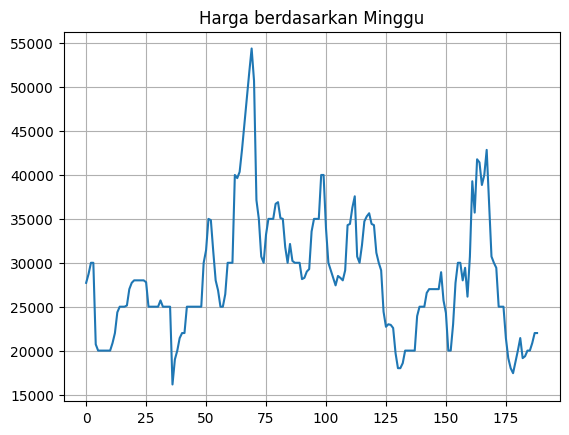

In [180]:
plt.plot(weekly_data['Harga/week'])
plt.title('Harga berdasarkan Minggu')
plt.grid(True)

In [181]:
# weekly_data.to_csv("weekly_data.csv", index=False)

## Data Preparation

In [182]:
week = np.array(weekly_data["Minggu"])
series = np.array(weekly_data['Harga/week'])
week.shape, series.shape

((189,), (189,))

In [183]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [184]:
def scaled_price(data):
    return data/1000

In [185]:
# Model configuration
window_size = 24

scaled_series = scaled_price(series)

X, y = create_sequences(scaled_series, window_size)

In [186]:
split_size1 = int(len(X) * 0.8)

week_train = week[:split_size1]
X_train = X[:split_size1]
y_train = y[:split_size1]

week_valid = week[split_size1:]
X_val = X[split_size1:]
y_val = y[split_size1:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((132, 24), (132,), (33, 24), (33,))

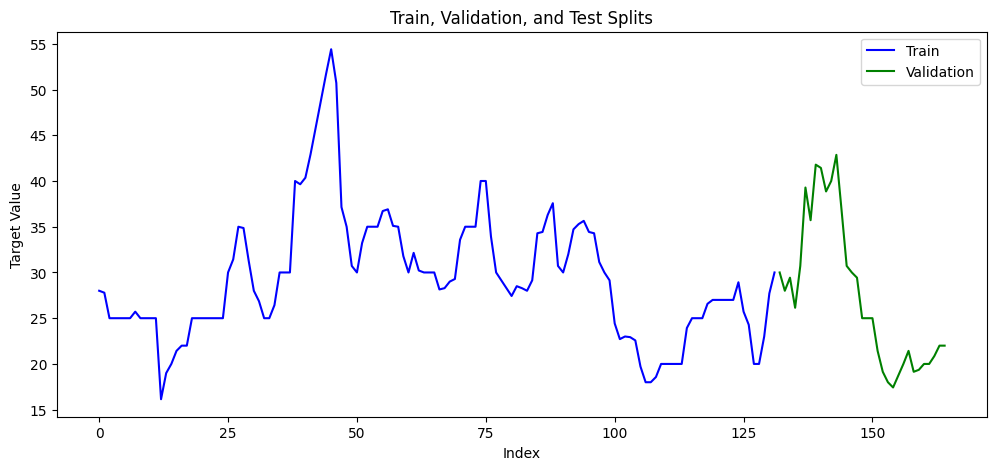

In [187]:
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(y_train)), y_train, label='Train', color='blue')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, label='Validation', color='green')

plt.xlabel('Index')
plt.ylabel('Target Value')
plt.legend()
plt.title('Train, Validation, and Test Splits')
plt.show()

## Train Model

### Model 1

In [191]:
def create_model(window_size):
    model = keras.Sequential([
        Input(shape=(window_size, 1)),
        Flatten(),
        # Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    return model

In [192]:
model_uncomplete = create_model(window_size)

model_uncomplete.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)                 │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

### Find lr

In [193]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model_uncomplete.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=optimizer)

# Train the model
history = model_uncomplete.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=140, batch_size=4, callbacks=[lr_schedule])

Epoch 1/140
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 22.4270 - val_loss: 19.6207 - learning_rate: 1.0000e-08
Epoch 2/140
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.6171 - val_loss: 19.6187 - learning_rate: 1.1220e-08
Epoch 3/140
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.3967 - val_loss: 19.6164 - learning_rate: 1.2589e-08
Epoch 4/140
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.7709 - val_loss: 19.6139 - learning_rate: 1.4125e-08
Epoch 5/140
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.6263 - val_loss: 19.6114 - learning_rate: 1.5849e-08
Epoch 6/140
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.2806 - val_loss: 19.6086 - learning_rate: 1.7783e-08
Epoch 7/140
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.7172 - val_loss: 19.6055 - learning_rate: 1.9953e-08
Epoch 8/140
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.3502 - val_loss: 19.6018 - learning_rate: 2.2387e-08
Epoch 9/140
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.0630 - val_loss: 1

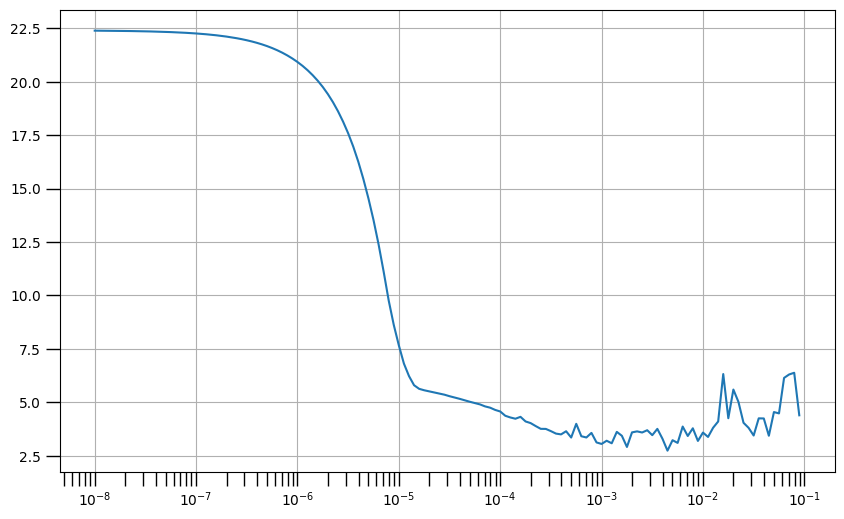

In [194]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(140) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
# plt.axis([1e-8, 1e-3, 0, 50])

### fit model 1

In [17]:
def custom_mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / y_true)) * 100

In [205]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Check the loss
        if logs['val_loss'] < 2.1:
            # Stop if threshold is met
            print("\Validation loss is lower than 10% so cancelling training!")
            self.model.stop_training = True

In [206]:
# Training Parameters
model = create_model(window_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0447)
model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsoluteError())

In [207]:
# Model Training
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=4, verbose=1, callbacks=[myCallback()])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 26.6728 - val_loss: 6.7535
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5492 - val_loss: 4.2694
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5568 - val_loss: 6.8206
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3802 - val_loss: 5.1645
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0305 - val_loss: 5.9807
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7373 - val_loss: 4.1610
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2155 - val_loss: 4.3030
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4732 - val_loss: 4.2545
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7348 - val_loss: 3.5330
Epoch 10/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1545 - val_loss: 2.9393
Epoch 11/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3017 - val_loss: 2.4849
Epoch 12/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.

### Visualisasi loss

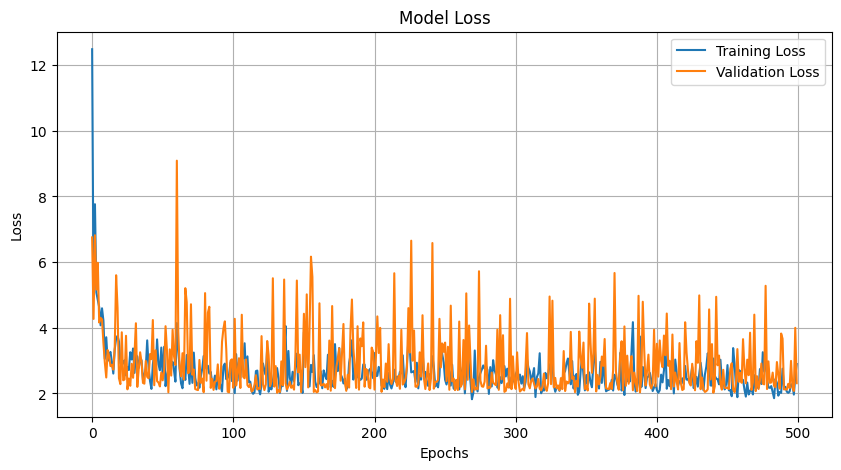

In [208]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Noise Dataset

In [ ]:
# Data Augmentation (di sini pakai Random Noise)
# tambah random noise ke training data
noise = np.random.normal(0, 0.1, X_train.shape)
X_train_noisy = X_train + noise
model.fit(X_train_noisy, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Regularization

In [ ]:
# Regularization (L2 Regularization)
model = keras.Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(WINDOW_SIZE, 1), kernel_regularizer=l2(0.01)))
model.add(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(LSTM(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1))

### Cross Validation

In [ ]:
# Membuat objek KFold dengan 5 fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan hasil cross-validation
cv_results = []
true_values = []
predictions = []

for train_index, val_index in kf.split(X):
    # Membagi data menjadi train dan validation set untuk setiap fold
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Membuat model
    model = keras.Sequential()
    model.add(Dense(128, activation='relu', input_shape=(WINDOW_SIZE, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    # Kompilasi model
    model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

    # Latih model
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=8, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Evaluasi model pada data validasi
    val_loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)

    # Menyimpan hasil evaluasi untuk setiap fold
    cv_results.append(val_loss)

    # Menyimpan true values dan predictions
    y_pred_fold = model.predict(X_val_fold)
    true_values.extend(y_val_fold)
    predictions.extend(y_pred_fold)

# Menghitung rata-rata dan standar deviasi loss dari cross-validation
mean_loss = np.mean(cv_results)
std_loss = np.std(cv_results)

# Menghitung MAE dan RMSE
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))

print(f'Rata-rata Loss dari Cross-Validation: {mean_loss}')
print(f'Standar Deviasi Loss dari Cross-Validation: {std_loss}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

## Forecast

### Train Forecast

In [209]:
def inverse_scale(data):
    return data*1000

In [210]:
predict = model.predict(X)
predict = inverse_scale(predict.flatten())
y_inverse = inverse_scale(y)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [211]:
predict.shape

(165,)

In [212]:
predict_result = pd.DataFrame(data={'Week':week[window_size:], 'Prediction':predict, 'actuals':y_inverse})
predict_result

,Week,Prediction,actuals
0,25,28066.677734,28000.000000
1,26,28529.373047,27785.714286
2,27,27748.382812,25000.000000
3,28,25020.892578,25000.000000
4,29,25766.132812,25000.000000
...,...,...,...
160,185,20322.476562,20000.000000
161,186,19407.599609,20000.000000
162,187,19722.044922,20857.142857
163,188,21604.949219,22000.000000


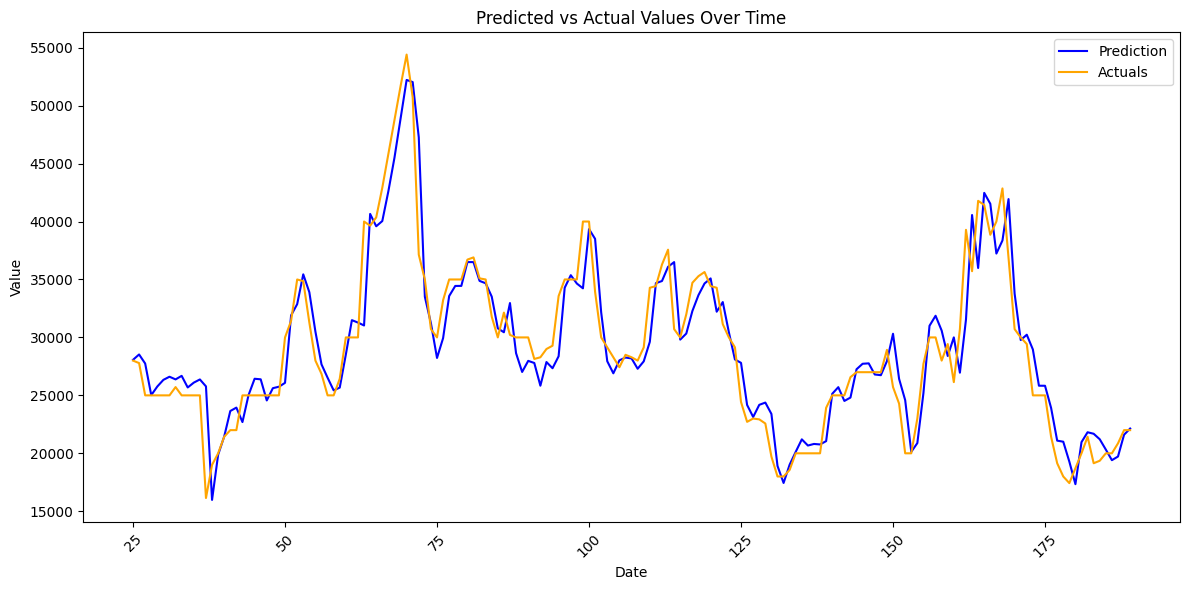

In [213]:
week_selected = 0
plt.figure(figsize=(12, 6))
plt.plot(predict_result['Week'][week_selected:], predict_result['Prediction'][week_selected:], label='Prediction', color='blue')
plt.plot(predict_result['Week'][week_selected:], predict_result['actuals'][week_selected:], label='Actuals', color='orange')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted vs Actual Values Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Validation Forecast

In [214]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_inverse, predict)
mse = mean_squared_error(y_inverse, predict)
rmse = np.sqrt(mse)

print(f'mae: {mae:.2f}')
print(f'mse: {mse:.2f}')
print(f'rmse: {rmse:.2f}')

mae: 1783.19
mse: 6286169.53
rmse: 2507.22


In [215]:
mape = np.mean(np.abs((y_inverse - predict) / y_inverse)) * 100
accuracy = 100 - mape
print(f"Akurasi prediksi: {accuracy:.2f}%")

Akurasi prediksi: 93.73%


### Save model

In [216]:
# save keras model
model.save('forecast_mingguan.keras')

### Future Forecast

In [217]:
loaded_model = tf.keras.models.load_model('forecast_mingguan.keras')

In [218]:
def inverse_scale(data):
    return data*1000

In [219]:
print(loaded_model.input_shape)

(None, 24, 1)


In [220]:
actual = series[:-30]
seq_res = np.array([])

# seq_res = predict_n_weeks(4, actual, seq_res)
# prediction(actual)
# seq_res

In [221]:
act_temp = actual.reshape(-1, 1)

In [222]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [223]:
seq_res

array([30003.55859375])

In [224]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [225]:
seq_res

array([30003.55859375, 31222.36328125])

In [226]:
print(weekly_data[(weekly_data['Minggu'] > 159) & (weekly_data['Minggu'] <= 161)])

     Minggu    Harga/week
159     160  26142.857143
160     161  30714.285714


In [227]:
actual = np.append(actual, [26142.85, 30714.28])

In [228]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [229]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [230]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875])

In [231]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [232]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438])

In [233]:
print(weekly_data[(weekly_data['Minggu'] > 161) & (weekly_data['Minggu'] <= 163)])

     Minggu    Harga/week
161     162  39285.714286
162     163  35714.285714


In [234]:
actual = np.append(actual, [39285.71, 35714.28])

In [235]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [236]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [237]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  ])

In [238]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [239]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125])

In [240]:
print(weekly_data[(weekly_data['Minggu'] > 163) & (weekly_data['Minggu'] <= 165)])

     Minggu    Harga/week
163     164  41785.714286
164     165  41428.571429


In [241]:
actual = np.append(actual, [41785.71, 41428.57])

In [242]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [243]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [244]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  ])

In [245]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [246]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ])

In [247]:
print(weekly_data[(weekly_data['Minggu'] > 165) & (weekly_data['Minggu'] <= 167)])

     Minggu    Harga/week
165     166  38857.142857
166     167  40000.000000


In [248]:
actual = np.append(actual, [38857.14, 40000.00])

In [249]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [250]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [251]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    ])

In [252]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [253]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  ])

In [254]:
print(weekly_data[(weekly_data['Minggu'] > 167) & (weekly_data['Minggu'] <= 169)])

     Minggu    Harga/week
167     168  42857.142857
168     169  36857.142857


In [255]:
actual = np.append(actual, [42857.14, 36857.14])

In [256]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [257]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [258]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 ])

In [259]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [260]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ])

In [261]:
print(weekly_data[(weekly_data['Minggu'] > 169) & (weekly_data['Minggu'] <= 171)])

     Minggu    Harga/week
169     170  30714.285714
170     171  30000.000000


In [262]:
actual = np.append(actual, [30714.28, 30000.00])

In [263]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [264]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [265]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875])

In [266]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


In [267]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812])

In [268]:
print(weekly_data[(weekly_data['Minggu'] > 171) & (weekly_data['Minggu'] <= 173)])

     Minggu    Harga/week
171     172  29428.571429
172     173  25000.000000


In [269]:
actual = np.append(actual, [29428.57, 25000.00])

In [270]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [271]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [272]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812, 25833.36328125])

In [273]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [274]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812, 25833.36328125, 26747.94335938])

In [275]:
print(weekly_data[(weekly_data['Minggu'] > 173) & (weekly_data['Minggu'] <= 175)])

     Minggu  Harga/week
173     174     25000.0
174     175     25000.0


In [276]:
actual = np.append(actual, [25000.00, 25000.00])

In [277]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [278]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [279]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812, 25833.36328125, 26747.94335938,
       23917.3046875 ])

In [280]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [281]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812, 25833.36328125, 26747.94335938,
       23917.3046875 , 23842.00976562])

In [282]:
print(weekly_data[(weekly_data['Minggu'] > 175) & (weekly_data['Minggu'] <= 177)])

     Minggu    Harga/week
175     176  21428.571429
176     177  19142.857143


In [283]:
actual = np.append(actual, [21428.57, 19142.85])

In [284]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [285]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [286]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812, 25833.36328125, 26747.94335938,
       23917.3046875 , 23842.00976562, 20999.9921875 ])

In [287]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [288]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812, 25833.36328125, 26747.94335938,
       23917.3046875 , 23842.00976562, 20999.9921875 , 22593.296875  ])

In [289]:
print(weekly_data[(weekly_data['Minggu'] > 177) & (weekly_data['Minggu'] <= 179)])

     Minggu    Harga/week
177     178  18000.000000
178     179  17428.571429


In [290]:
actual = np.append(actual, [18000.00, 17428.57])

In [291]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [292]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [293]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812, 25833.36328125, 26747.94335938,
       23917.3046875 , 23842.00976562, 20999.9921875 , 22593.296875  ,
       17335.6015625 ])

In [294]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [295]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812, 25833.36328125, 26747.94335938,
       23917.3046875 , 23842.00976562, 20999.9921875 , 22593.296875  ,
       17335.6015625 , 19445.75390625])

In [296]:
print(weekly_data[(weekly_data['Minggu'] > 179) & (weekly_data['Minggu'] <= 181)])

     Minggu    Harga/week
179     180  18714.285714
180     181  20000.000000


In [297]:
actual = np.append(actual, [18714.28, 20000.00])

In [298]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [299]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [300]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812, 25833.36328125, 26747.94335938,
       23917.3046875 , 23842.00976562, 20999.9921875 , 22593.296875  ,
       17335.6015625 , 19445.75390625, 21816.87109375])

In [301]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [302]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812, 25833.36328125, 26747.94335938,
       23917.3046875 , 23842.00976562, 20999.9921875 , 22593.296875  ,
       17335.6015625 , 19445.75390625, 21816.87109375, 22115.37890625])

In [303]:
print(weekly_data[(weekly_data['Minggu'] > 181) & (weekly_data['Minggu'] <= 183)])

     Minggu    Harga/week
181     182  21428.571429
182     183  19142.857143


In [304]:
actual = np.append(actual, [21428.57, 19142.85])

In [305]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [306]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [307]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [308]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812, 25833.36328125, 26747.94335938,
       23917.3046875 , 23842.00976562, 20999.9921875 , 22593.296875  ,
       17335.6015625 , 19445.75390625, 21816.87109375, 22115.37890625,
       21212.25195312, 22371.24609375])

In [309]:
print(weekly_data[(weekly_data['Minggu'] > 183) & (weekly_data['Minggu'] <= 185)])

     Minggu    Harga/week
183     184  19357.142857
184     185  20000.000000


In [310]:
actual = np.append(actual, [19357.14, 20000.00])

In [311]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [312]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [313]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [314]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812, 25833.36328125, 26747.94335938,
       23917.3046875 , 23842.00976562, 20999.9921875 , 22593.296875  ,
       17335.6015625 , 19445.75390625, 21816.87109375, 22115.37890625,
       21212.25195312, 22371.24609375, 19407.59960938, 19068.01367188])

In [315]:
print(weekly_data[(weekly_data['Minggu'] > 185) & (weekly_data['Minggu'] <= 187)])

     Minggu    Harga/week
185     186  20000.000000
186     187  20857.142857


In [316]:
actual = np.append(actual, [20000.00, 20857.14])

In [317]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [318]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [319]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [320]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812, 25833.36328125, 26747.94335938,
       23917.3046875 , 23842.00976562, 20999.9921875 , 22593.296875  ,
       17335.6015625 , 19445.75390625, 21816.87109375, 22115.37890625,
       21212.25195312, 22371.24609375, 19407.59960938, 19068.01367188,
       21604.9453125 , 21700.44726562])

In [321]:
print(weekly_data[(weekly_data['Minggu'] > 187) & (weekly_data['Minggu'] <= 189)])

     Minggu  Harga/week
187     188     22000.0
188     189     22000.0


In [322]:
actual = np.append(actual, [22000.00, 22000.00])

In [323]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [324]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [325]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [326]:
seq_res

array([30003.55859375, 31222.36328125, 31547.04296875, 32016.02148438,
       35990.765625  , 36073.14453125, 41530.953125  , 40189.25      ,
       38365.8125    , 36976.828125  , 33773.7109375 , 33154.21875   ,
       30232.44921875, 29850.70507812, 25833.36328125, 26747.94335938,
       23917.3046875 , 23842.00976562, 20999.9921875 , 22593.296875  ,
       17335.6015625 , 19445.75390625, 21816.87109375, 22115.37890625,
       21212.25195312, 22371.24609375, 19407.59960938, 19068.01367188,
       21604.9453125 , 21700.44726562, 21801.06640625, 22425.71679688])

In [327]:
actual[-32:]

array([28000.        , 29428.57142857, 26142.85      , 30714.28      ,
       39285.71      , 35714.28      , 41785.71      , 41428.57      ,
       38857.14      , 40000.        , 42857.14      , 36857.14      ,
       30714.28      , 30000.        , 29428.57      , 25000.        ,
       25000.        , 25000.        , 21428.57      , 19142.85      ,
       18000.        , 17428.57      , 18714.28      , 20000.        ,
       21428.57      , 19142.85      , 19357.14      , 20000.        ,
       20000.        , 20857.14      , 22000.        , 22000.        ])

In [328]:
actual = np.append(actual, [28000.00, 28000.00])

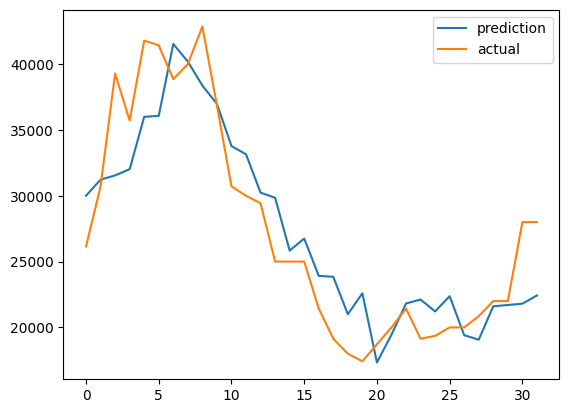

In [329]:
plt.plot(seq_res, label='prediction')
plt.plot(actual[-32:], label='actual')
plt.legend()

In [330]:
mae = mean_absolute_error(seq_res, actual[-32:])
mse = mean_squared_error(seq_res, actual[-32:])
rmse = np.sqrt(mse)

print(f'mae: {mae:.2f}')
print(f'mse: {mse:.2f}')
print(f'rmse: {rmse:.2f}')

mae: 2768.81
mse: 11971923.75
rmse: 3460.05


In [331]:
mape = np.mean(np.abs((seq_res - actual[-32:]) / seq_res)) * 100
accuracy = 100 - mape
print(f"Akurasi prediksi: {accuracy:.2f}%")

Akurasi prediksi: 89.71%


In [ ]:
def predict_2_weeks(actual):
    act_temp = actual.reshape(-1, 1)
    seq_res = np.array([])
    for i in range(2):
        actual_scaled = scaled_price(act_temp)
        seq = actual_scaled[-window_size:]
        hasil = model.predict(seq.reshape(1, window_size, 1))
        hasil = inverse_scale(hasil)
        seq_res = np.append(seq_res, hasil.item())
        act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))
    return act_temp, seq_res

## Deploy Model

In [652]:
export_dir = 'saved_model/1'

tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


In [653]:
# Select mode of optimization
mode = "Default" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [654]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert();

In [656]:
import pathlib

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

23584

## Load Model

In [657]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]